In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import lcls_beamline_toolbox.utility.util as util
import copy
import scipy.spatial.transform as transform
from lcls_beamline_toolbox.models.split_and_delay_motion import SND

RuntimeError: 'widget' is not a recognised GUI loop or backend name

## Hard X-ray Split and Delay

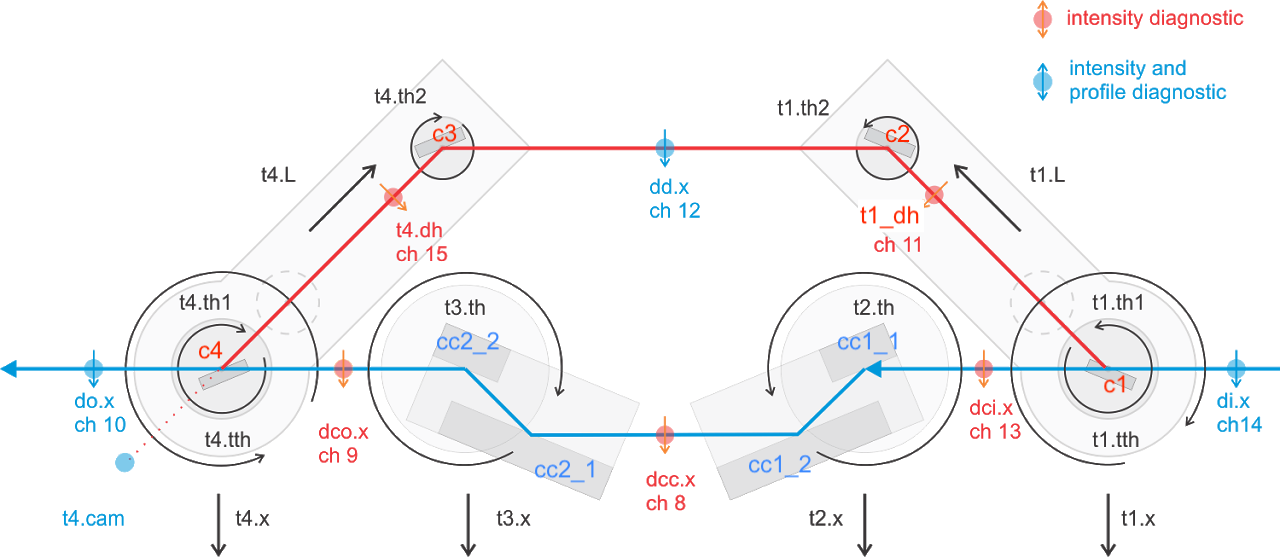


See above figure for diagnostics, optics, and degrees of freedom definitions. The image is taken from the XCS confluence page: [Hard X-ray Split-Delay System](https://confluence.slac.stanford.edu/x/ihZSDg), and further details about the system design can be found in [the paper by Zhu et al.](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/10237/1/Development-of-a-hard-x-ray-split-delay-system-at/10.1117/12.2265171.short)

# List of Inputs for "delay branch" (red line)
- t1_tth
- t1_th1
- t1_th2
- t4_th2
- t4_th1
- t4_tth
- t1_L (add later)
- t4_L (add later)
- t1_chi1 (add later)
- t1_chi2 (add later)
- t4_chi1 (add later)
- t4_chi2 (add later)

### Let's start with a range of [-100e-6, 100e-6] for the first six degrees of freedom listed above for now.

# List of outputs for "delay branch"
- t1_dh_sum
- dd_sum
- t4_dh_sum
- do_sum
- dd_cx (optional for now)
- do_cx (optional for now)

### The "sum" outputs should be maximized, while for the "cx" outputs the absolute value (deviation from zero) should be minimized. Some of the outputs may be redundant.

# Usage
Inputs can be adjusted using functions defined in split_and_delay.py. For relative adjustment, the function is mvr_{input name}, and to move to an absolute position, the function is mv_{input name}.

Outputs can be calculated by first propagating the beam through the system (snd.propagate_delay()), followed by querying the output as get_{output name}.

See below for two simple examples. Note that in both examples, the "cx"/position output may not be meaningful when the "sum"/intensity output is low.

In [2]:
intensity = np.zeros((41,41))
overlap = np.zeros((41,41))
th1_delta = np.linspace(-100e-6,100e-6,41)
th1_delta, th2_delta = np.meshgrid(th1_delta,th1_delta)

# initialize split and delay object
snd = SND(9500,delay=280e-3)

# t1_tth positions
th1_positions = snd.t1_th1.wm() + th1_delta
th2_positions = snd.t1_th2.wm() + th2_delta

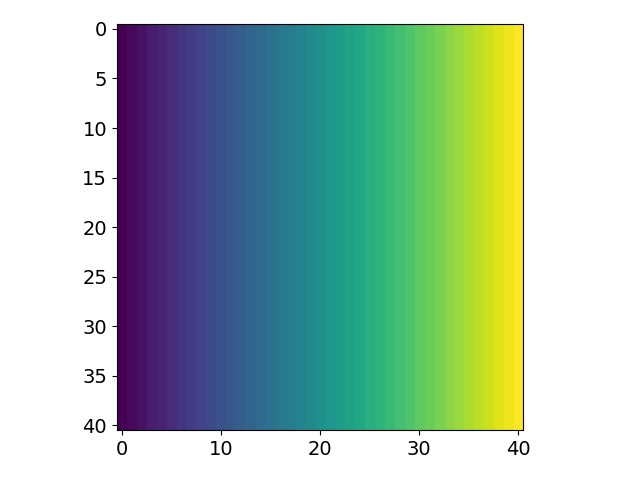

In [3]:
plt.figure()
plt.imshow(th1_positions)

In [4]:
%%capture capt

for i in range(41):
    for j in range(41):
        snd.t1_th1.mv(th1_positions[j,i])
        snd.t1_th2.mv(th2_positions[j,i])
        snd.propagate_delay()
        intensity[j,i] = snd.get_do_sum() + snd.get_IP_sum()
        overlap[j,i] = snd.get_IP_r()

Text(0.5, 1.0, 'delay=maximum')

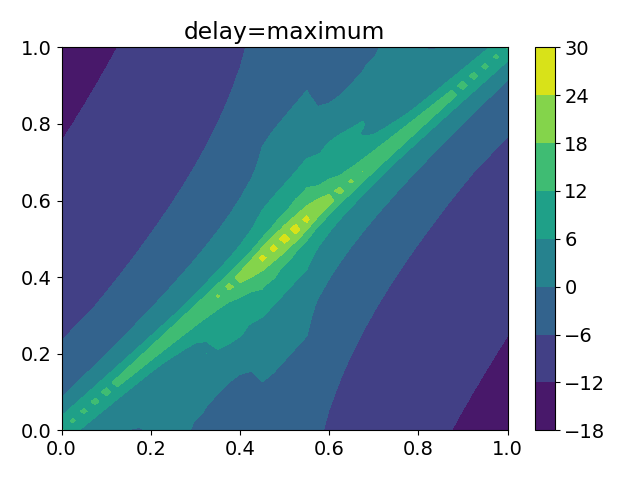

In [6]:
plt.figure()
plt.contourf(np.linspace(0,1,41),np.linspace(0,1,41),np.log((intensity/overlap)))
plt.colorbar()
plt.title('delay=maximum')

<IPython.core.display.Javascript object>


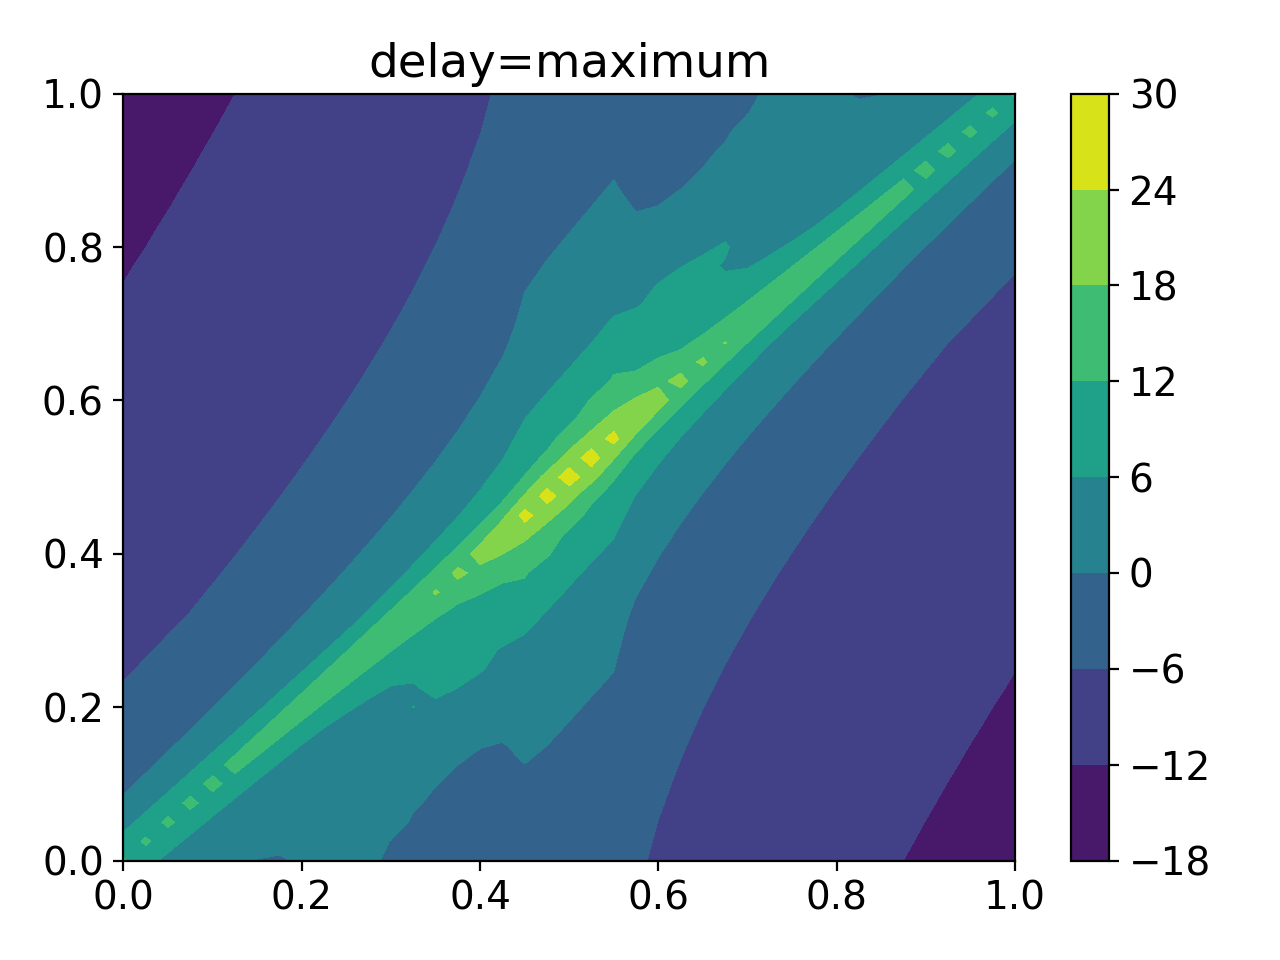

Text(0.5, 1.0, 'delay=maximum')

In [27]:
plt.figure()
plt.contourf(np.linspace(0,1,41),np.linspace(0,1,41),np.log((output/overlap)))
plt.colorbar()
plt.title('delay=maximum')

In [28]:
intensity = np.zeros((41,41))
overlap = np.zeros((41,41))
th1_delta = np.linspace(-100e-6,100e-6,41)
th1_delta, th2_delta = np.meshgrid(th1_delta,th1_delta)

# initialize split and delay object
snd = SND(9500)

# t1_tth positions
th1_positions = snd.t1_th1.wm() + th1_delta
th2_positions = snd.t1_th2.wm() + th2_delta

<IPython.core.display.Javascript object>


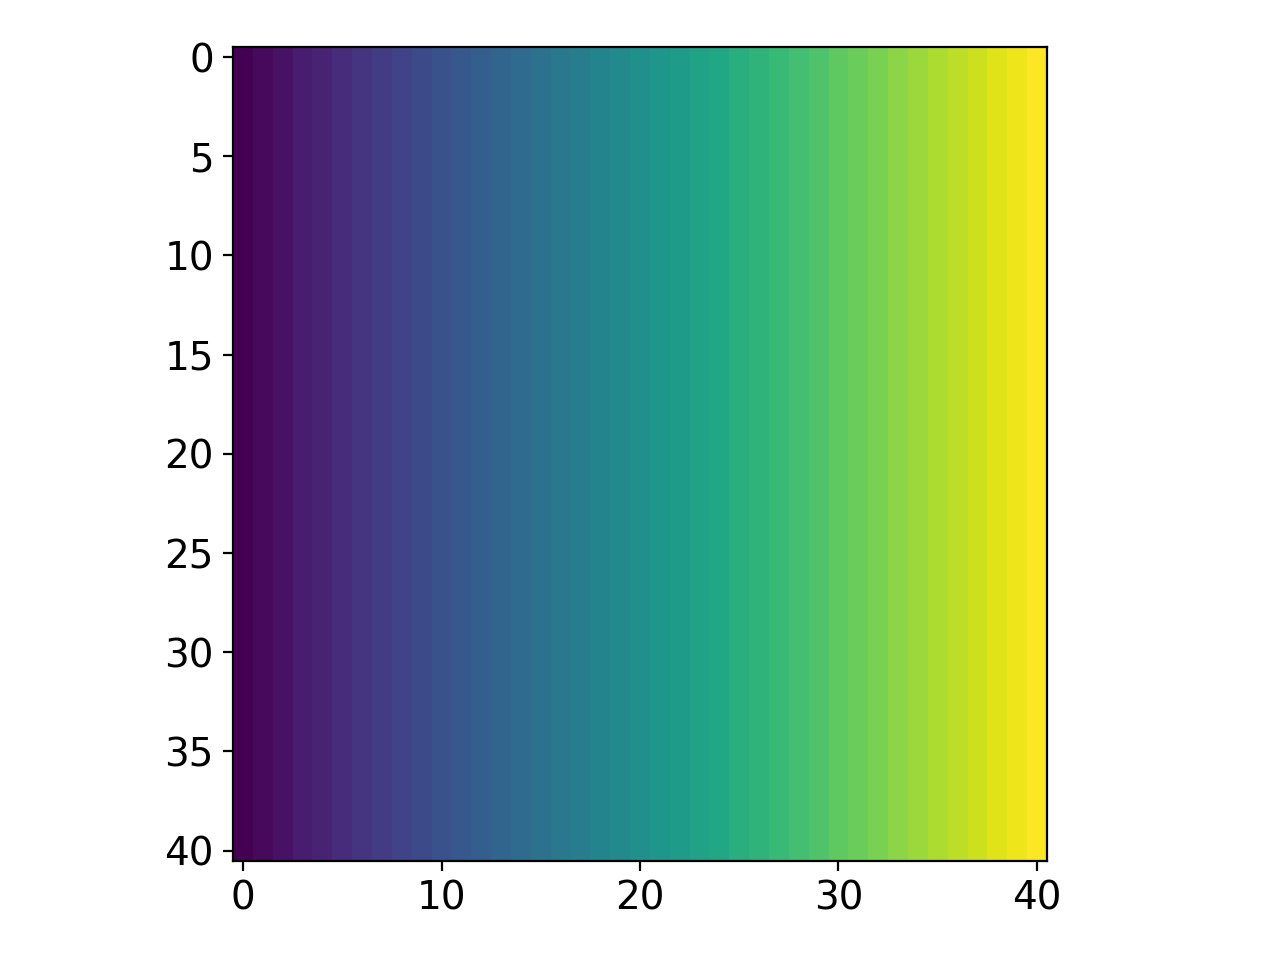

In [29]:
plt.figure()
plt.imshow(th1_positions)

In [30]:
%%capture capt

for i in range(41):
    for j in range(41):
        snd.t1_th1.mv(th1_positions[j,i])
        snd.t1_th2.mv(th2_positions[j,i])
        snd.propagate_delay()
        intensity[j,i] = snd.get_do_sum() + snd.get_IP_sum()
        overlap[j,i] = snd.get_IP_r()

<IPython.core.display.Javascript object>


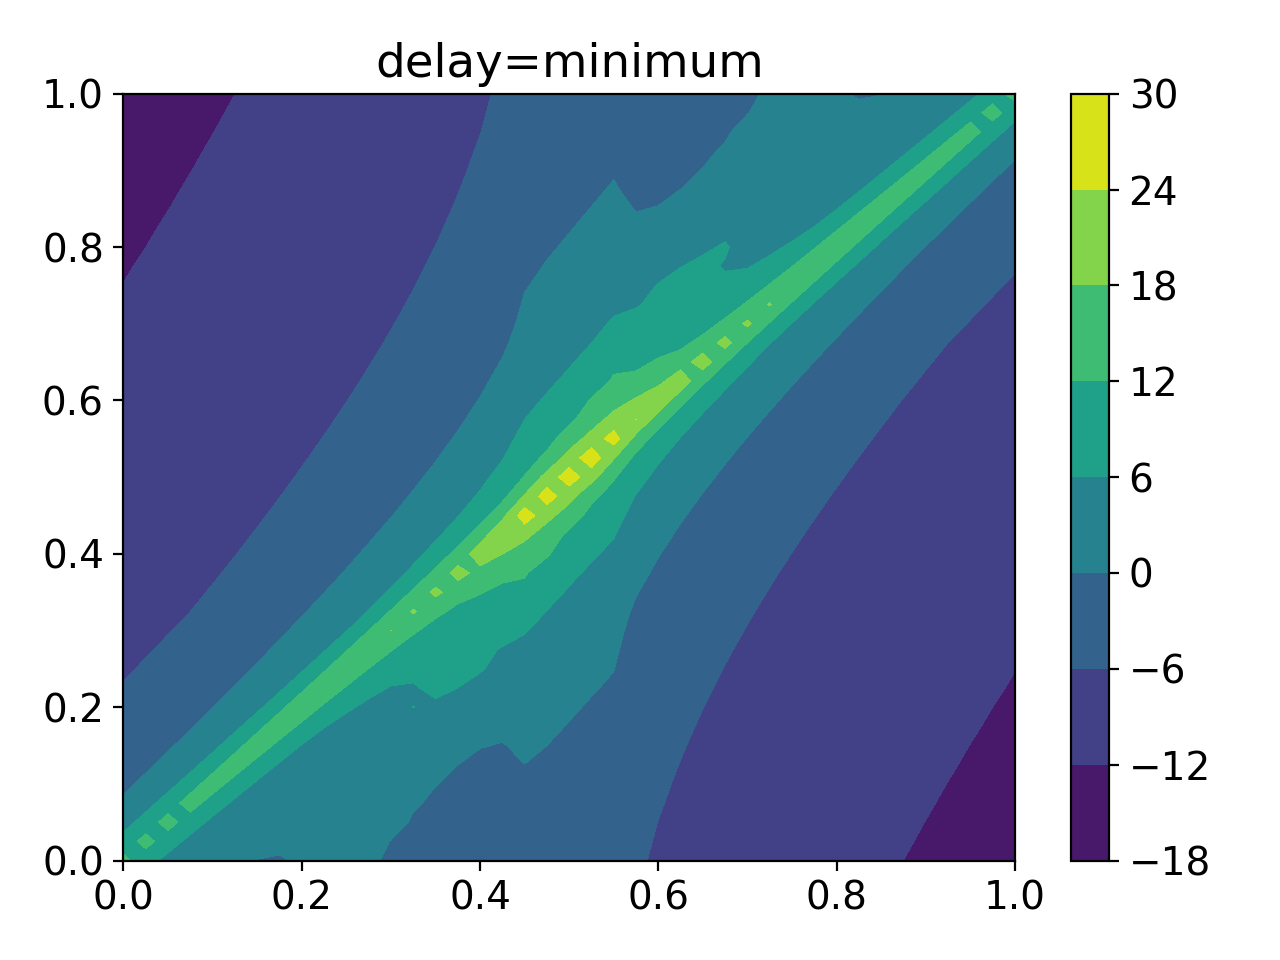

Text(0.5, 1.0, 'delay=minimum')

In [31]:
plt.figure()
plt.contourf(np.linspace(0,1,41),np.linspace(0,1,41),np.log((output/overlap)))
plt.colorbar()
plt.title('delay=minimum')

<IPython.core.display.Javascript object>


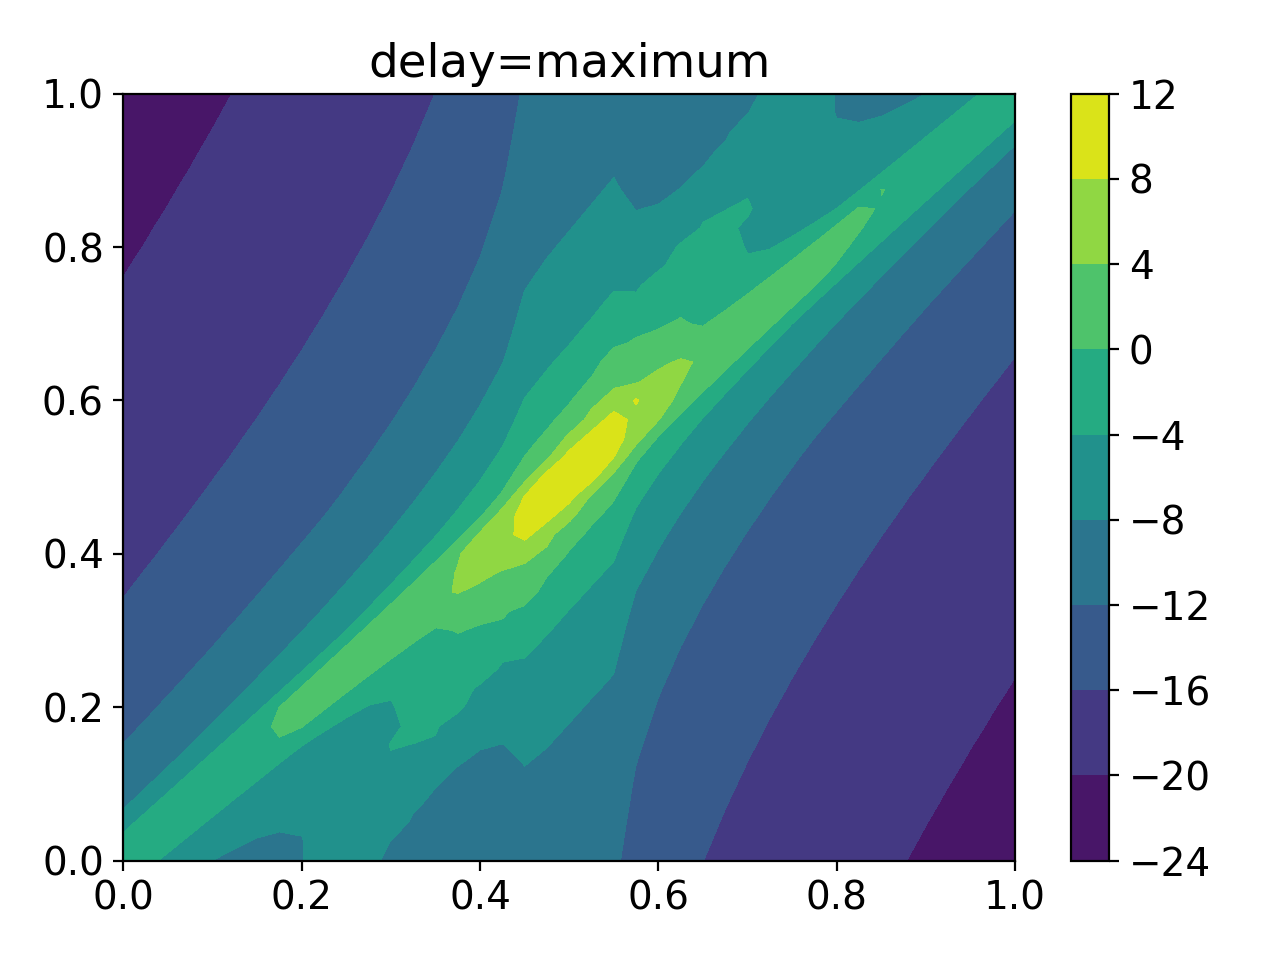

Text(0.5, 1.0, 'delay=maximum')

In [24]:
plt.figure()
plt.contourf(np.linspace(0,1,41),np.linspace(0,1,41),np.log((output)))
plt.colorbar()
plt.title('delay=maximum')

<IPython.core.display.Javascript object>


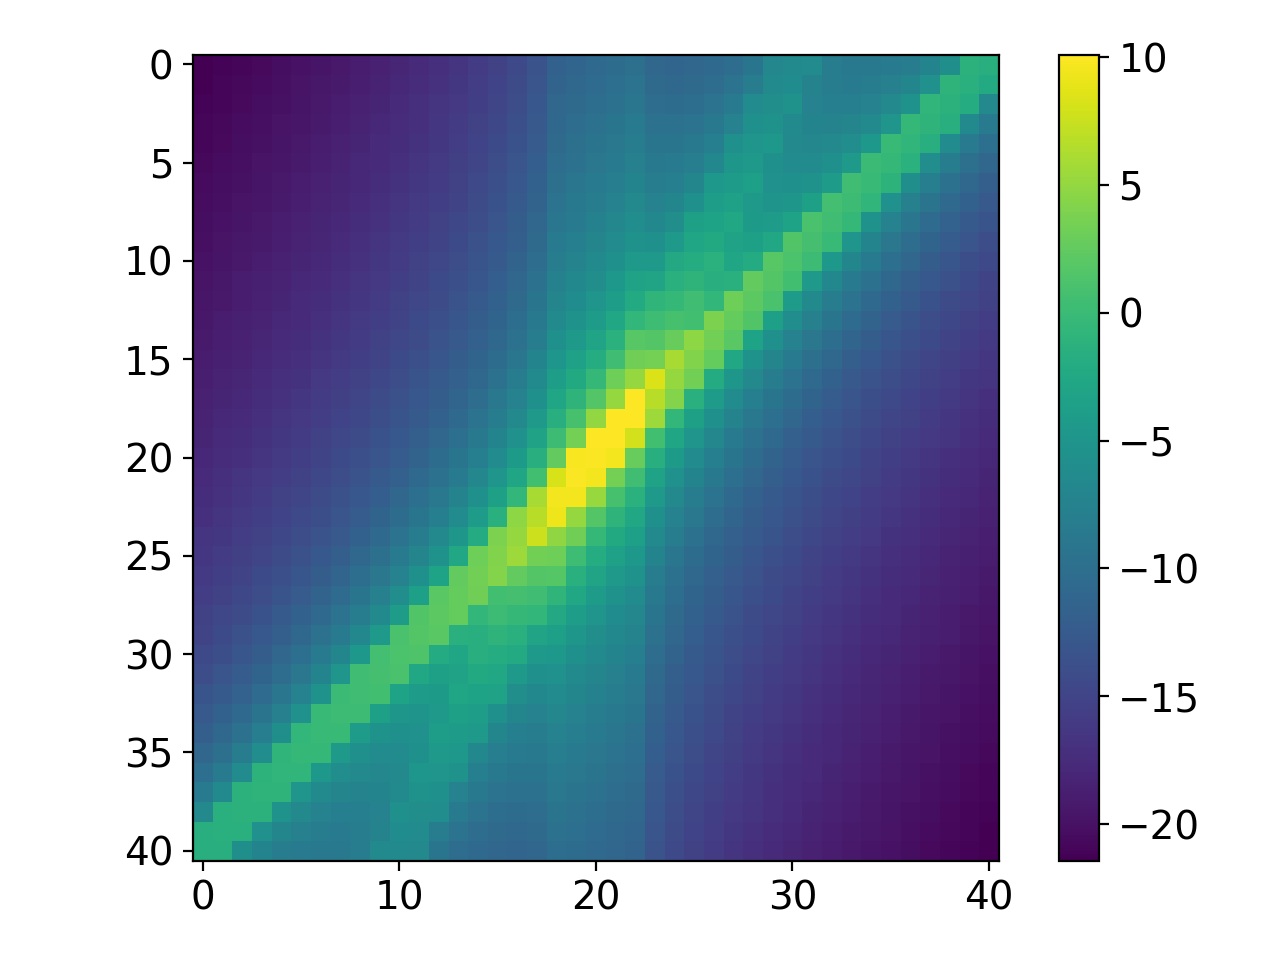

<IPython.core.display.Javascript object>


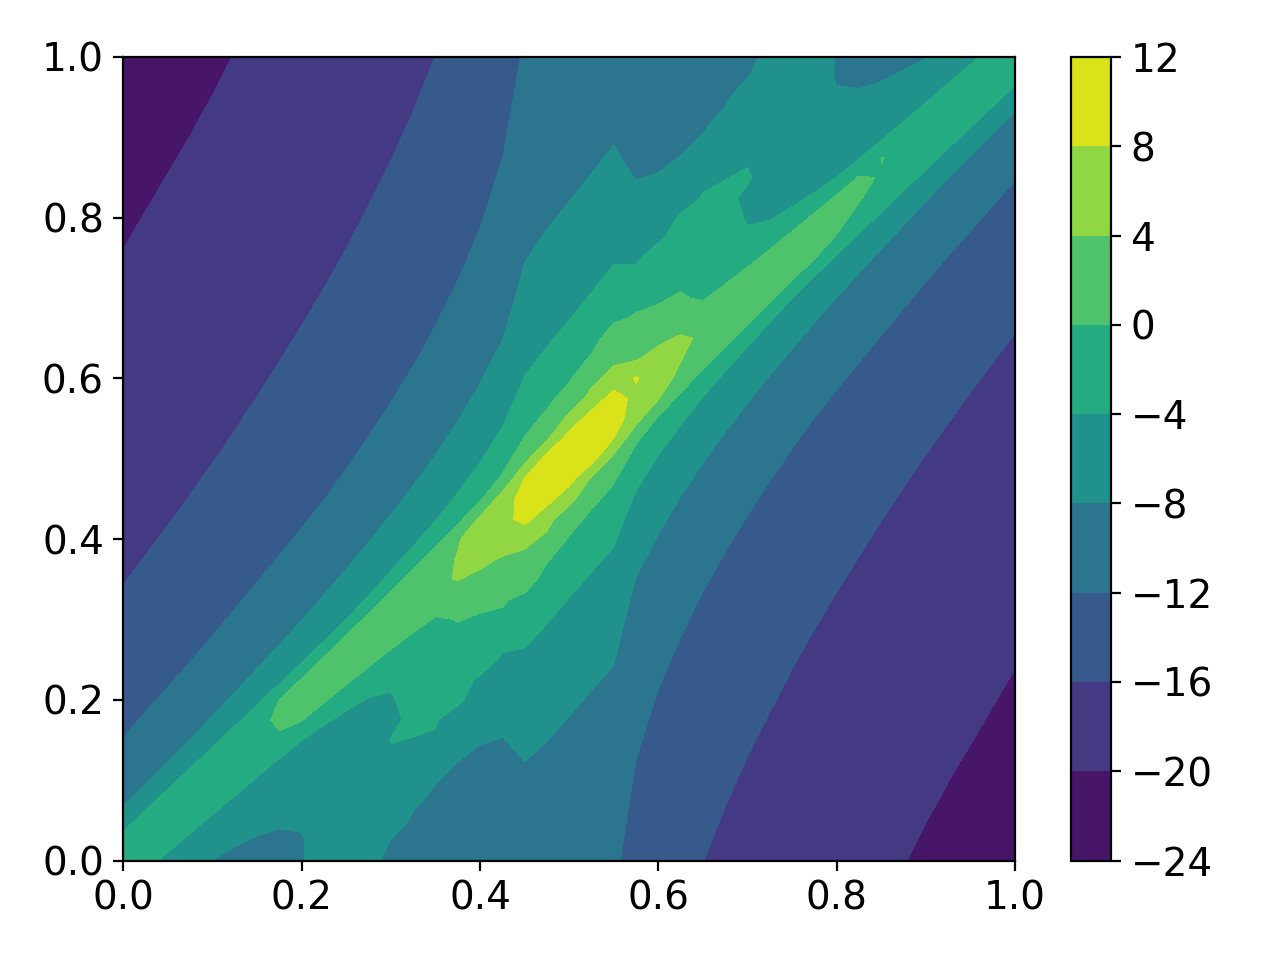

In [21]:
plt.figure()
plt.imshow(np.log(np.flipud(output)))
plt.colorbar()

plt.figure()
plt.contourf(np.linspace(0,1,41),np.linspace(0,1,41),np.log((output)))
plt.colorbar()

In [25]:
%%capture capt

rocking = np.zeros(81)

deltas = np.linspace(-53e-6,53e-6,81)
centroids = np.zeros_like(rocking)
cy = np.zeros_like(rocking)

# initialize split and delay object
snd = SND(9880)

# t1_tth positions
positions = snd.t1_th2.wm() + deltas + 1.2e-6

# loop through positions
for num,pos in enumerate(positions):
    
    # make adjustment to t1_tth
    snd.t1_th2.mv(pos)
    # propagate beam through system
    snd.propagate_delay()
    
    # get outputs
    rocking[num] = snd.get_dd_sum()#+snd.get_IP_sum()
    centroids[num] = snd.get_IP_cx()
    cy[num] = snd.get_IP_cy()

<IPython.core.display.Javascript object>


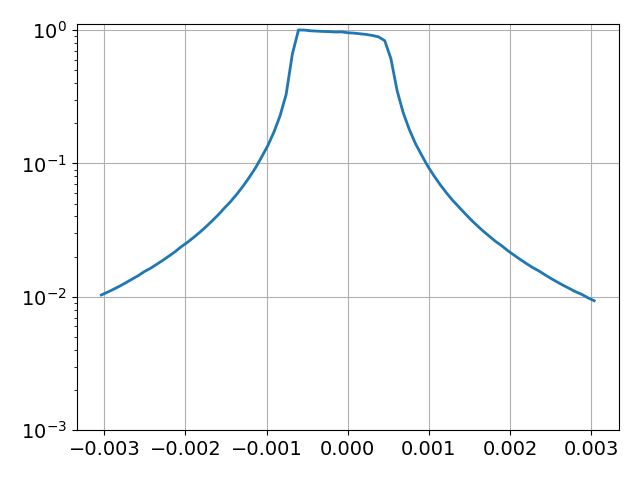

In [28]:
plt.figure()
plt.semilogy((positions-np.mean(positions))*180/np.pi,rocking/np.max(rocking))
plt.ylim(1e-3,1.1)
plt.grid()

In [2]:
%%capture capt

rocking = np.zeros(81)

deltas = np.linspace(-100e-6,100e-6,81)
centroids = np.zeros_like(rocking)
cy = np.zeros_like(rocking)

# initialize split and delay object
snd = SND(9500)

# t1_tth positions
positions = snd.t1_chi1.wm() + deltas + 1.2e-6

# loop through positions
for num,pos in enumerate(positions):
    
    # make adjustment to t1_tth
    snd.t1_chi1.mv(pos)
    # propagate beam through system
    snd.propagate_delay()
    
    # get outputs
    rocking[num] = snd.get_t1_dh_sum()#+snd.get_IP_sum()
    centroids[num] = snd.get_IP_cx()
    cy[num] = snd.get_IP_cy()

<IPython.core.display.Javascript object>


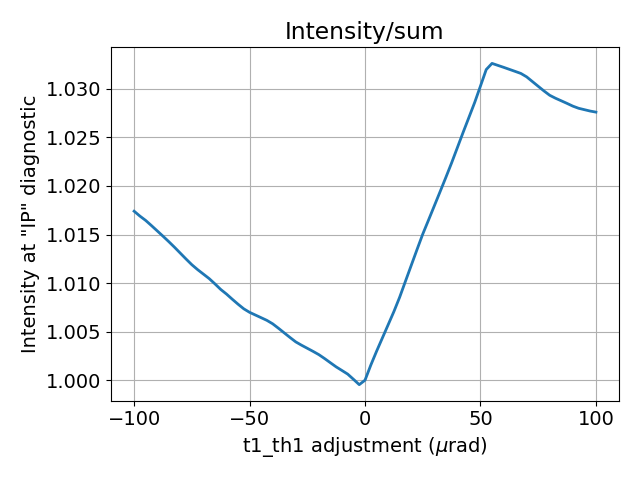

<IPython.core.display.Javascript object>


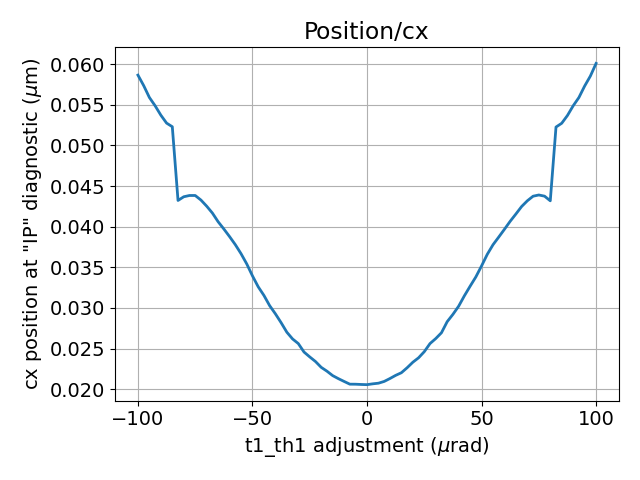

<IPython.core.display.Javascript object>


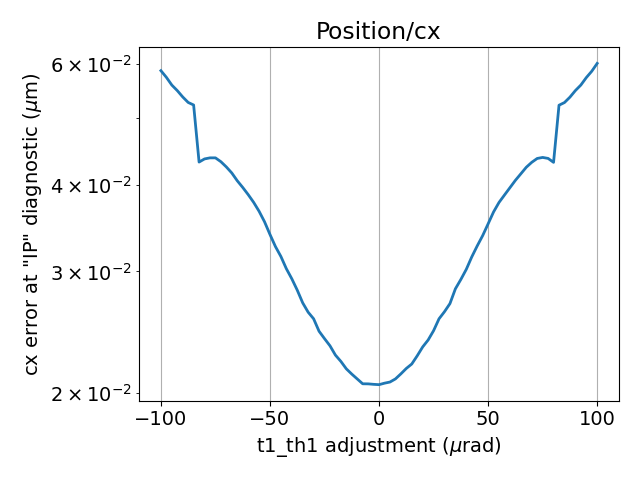

<IPython.core.display.Javascript object>


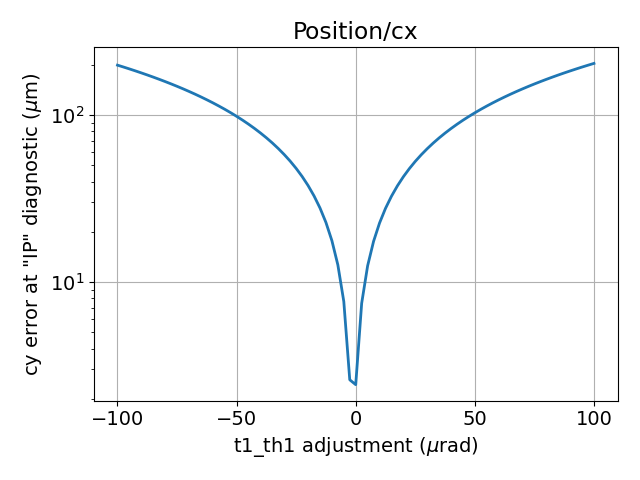

In [3]:
plt.figure()
plt.plot(deltas*1e6,rocking/rocking[40])
plt.xlabel('t1_th1 adjustment ($\mu$rad)')
plt.ylabel('Intensity at "IP" diagnostic')
plt.title('Intensity/sum')
plt.grid()

plt.figure()
plt.plot(deltas*1e6,centroids*1e6)
plt.xlabel('t1_th1 adjustment ($\mu$rad)')
plt.ylabel('cx position at "IP" diagnostic ($\mu$m)')
plt.title('Position/cx')
plt.grid()

plt.figure()
plt.semilogy(deltas*1e6,np.abs(centroids)*1e6)
plt.xlabel('t1_th1 adjustment ($\mu$rad)')
plt.ylabel('cx error at "IP" diagnostic ($\mu$m)')
plt.title('Position/cx')
plt.grid()

plt.figure()
plt.semilogy(deltas*1e6,np.abs(cy)*1e6)
plt.xlabel('t1_th1 adjustment ($\mu$rad)')
plt.ylabel('cy error at "IP" diagnostic ($\mu$m)')
plt.title('Position/cx')
plt.grid()

# Delay calculations
Below the possible delay ranges between the two branches are calculated based on adjusting the t1_L and t4_L inputs. This is consistent with calculations shown in the paper linked at the top of the notebook (Zhu et al).

In [4]:
%%capture capt

rocking = np.zeros(21)
E0 = np.linspace(6500,13000,21)
delay_cc = np.zeros(21)
delay_dd = np.zeros(21)

deltas = np.linspace(-1*np.pi/180,1*np.pi/180,21)
centroids = np.zeros_like(rocking)

xpos = np.zeros_like(rocking)
zpos = np.zeros_like(rocking)
xpos2 = np.zeros_like(rocking)
zpos2 = np.zeros_like(rocking)



for num,energy in enumerate(E0):

    snd = SND(energy)
    
#     cc_branch = define_cc(energy)
    
#     delay_branch = define_delay(energy)
#     beam_params['photonEnergy'] = energy
#     b1 = beam.Beam(beam_params=beam_params)
#     b2 = beam.Beam(beam_params=beam_params)
    snd.propagate_cc()
    snd.propagate_delay()

#     delay_cc[num] = b3.group_delay
#     delay_dd[num] = b4.group_delay
    delay_cc[num] = snd.cc_branch.IP.group_delay
    delay_dd[num] = snd.delay_branch.IP.group_delay

In [5]:
%%capture capt

rocking = np.zeros(21)
E0 = np.linspace(6500,13000,21)
delay_cc = np.zeros(21)
delay_dd2 = np.zeros(21)
delay_bypass = np.zeros(21)

deltas = np.linspace(-1*np.pi/180,1*np.pi/180,21)
centroids = np.zeros_like(rocking)

xpos = np.zeros_like(rocking)
zpos = np.zeros_like(rocking)
xpos2 = np.zeros_like(rocking)
zpos2 = np.zeros_like(rocking)



for num,energy in enumerate(E0):

    snd = SND(energy)
    snd.t1_L.mv(280e-3)
    snd.t4_L.mv(280e-3)

    snd.propagate_cc()
    snd.propagate_delay()
    snd.propagate_bypass()

    delay_cc[num] = snd.cc_branch.IP.group_delay
    delay_dd2[num] = snd.delay_branch.IP.group_delay
    delay_bypass[num] = snd.bypass_branch.IP.group_delay

<IPython.core.display.Javascript object>


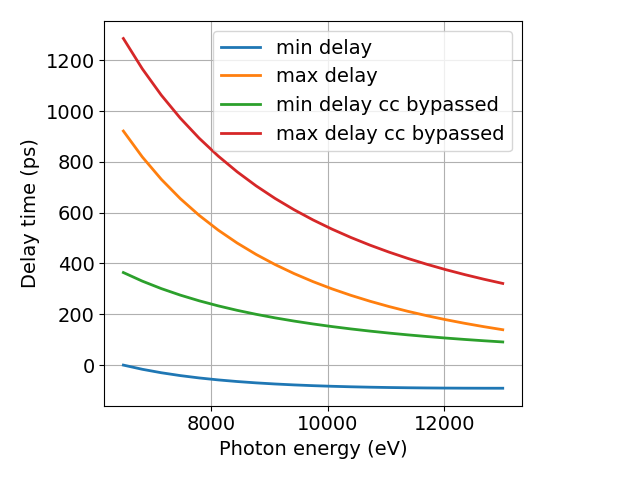

Text(0, 0.5, 'Delay time (ps)')

In [6]:
plt.figure()
plt.plot(E0, (delay_dd-delay_cc)*1e12,label='min delay')
plt.plot(E0, (delay_dd2-delay_cc)*1e12,label='max delay')
plt.plot(E0, (delay_dd-delay_bypass)*1e12,label='min delay cc bypassed')
plt.plot(E0, (delay_dd2-delay_bypass)*1e12,label='max delay cc bypassed')
plt.legend()
plt.grid()
plt.xlabel('Photon energy (eV)')
plt.ylabel('Delay time (ps)')

<IPython.core.display.Javascript object>


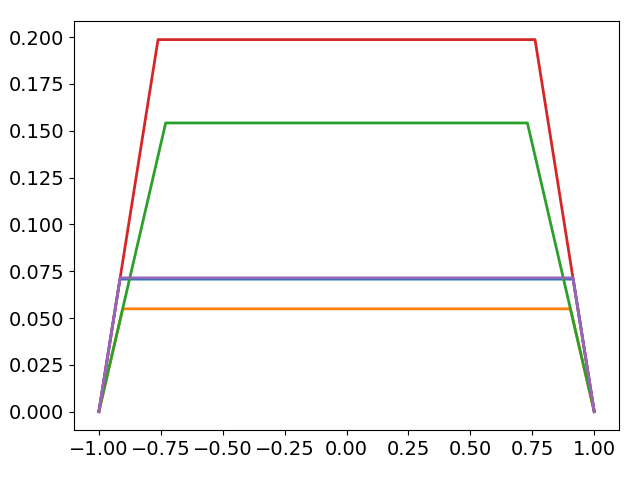

In [7]:
def get_crystal_positions(snd):
    s = np.s_[0::2]
    c1 = snd.delay_branch.c1.get_pos()[s]
    c2 = snd.delay_branch.c2.get_pos()[s]
    c3 = snd.delay_branch.c3.get_pos()[s]
    c4 = snd.delay_branch.c4.get_pos()[s]
    
    return np.array([c1[1],c2[1],c3[1],c4[1]]), np.array([c1[0],c2[0],c3[0],c4[0]])
    

snd = SND(9500)

pos = get_crystal_positions(snd)
fig, ax = plt.subplots(1,1)
ax.plot(pos[0]-np.mean(pos[0]),pos[1])

snd.t1_tth.mvr(10*np.pi/180)
snd.t4_tth.mvr(10*np.pi/180)
pos1 = get_crystal_positions(snd)
ax.plot(pos1[0]-np.mean(pos[0]),pos1[1])
# ax.set_ylim(-1,1)

snd.t1_L.mvr(200e-3)
snd.t4_L.mvr(200e-3)
pos1 = get_crystal_positions(snd)
ax.plot(pos1[0]-np.mean(pos[0]),pos1[1])
# ax.set_aspect('equal')
# ax.set_xlim(-1,-.7)
# ax.set_ylim(0,.3)

snd.t1_tth.mvr(-10*np.pi/180)
snd.t4_tth.mvr(-10*np.pi/180)
pos1 = get_crystal_positions(snd)
ax.plot(pos1[0]-np.mean(pos[0]),pos1[1])
# ax.set_ylim(-1,1)

snd.t1_L.mvr(-199e-3)
snd.t4_L.mvr(-199e-3)
pos1 = get_crystal_positions(snd)
ax.plot(pos1[0]-np.mean(pos[0]),pos1[1])

In [19]:
test = np.linspace(1,100,3)
print(test[np.s_[0::2]])
print(test[0::2])

[  1. 100.]
[  1. 100.]


In [249]:
beam_params = {
            'photonEnergy': 9500,
            'N': 2048,
            'sigma_x': 30e-6,
            'sigma_y': 30e-6,
            'rangeFactor': 5,
            'scaleFactor': 10,
            'z_source': 650 - 26
        }

envelope_sum = np.zeros(224)
time_sum = np.zeros(224)
num_pulses = 500
for i in range(num_pulses):
    pulse = beam.Pulse(beam_params=beam_params, tau=5, time_window=25, SASE=True, num_spikes=20)
    envelope_sum += np.abs(pulse.envelope)**2
    time_sum += np.abs(pulse.pulse)**2

<IPython.core.display.Javascript object>


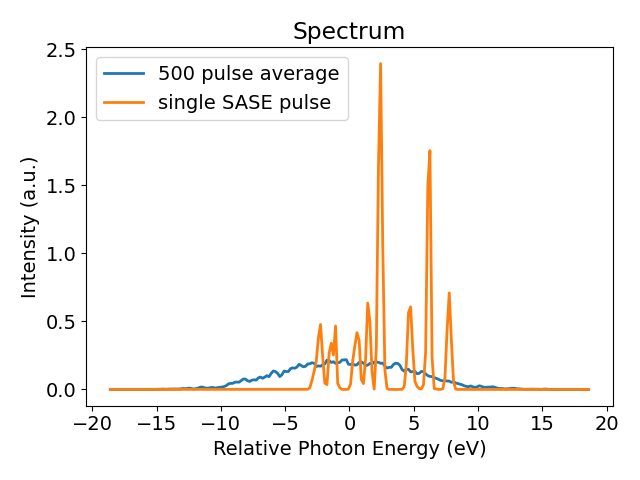

<IPython.core.display.Javascript object>


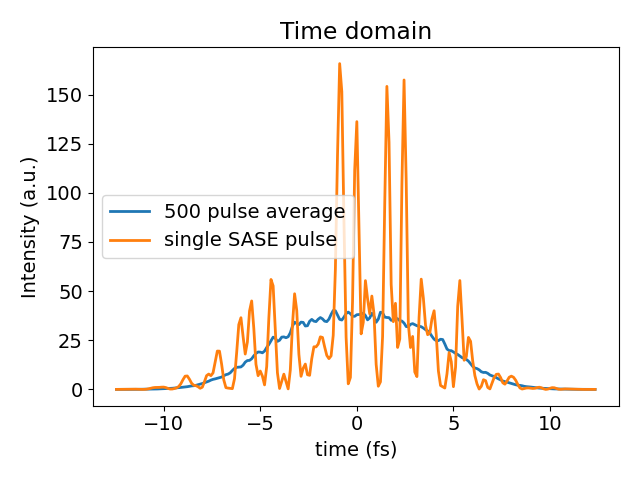

In [253]:
plt.figure()
plt.plot(pulse.energy-pulse.E0,envelope_sum/num_pulses,label='500 pulse average')
plt.plot(pulse.energy-pulse.E0,np.abs(pulse.envelope)**2,label='single SASE pulse')
plt.xlabel('Relative Photon Energy (eV)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.title('Spectrum')
plt.tight_layout()

plt.figure()
plt.plot(pulse.t_axis,time_sum/num_pulses,label='500 pulse average')
plt.plot(pulse.t_axis,np.abs(pulse.pulse)**2,label='single SASE pulse')
plt.xlabel('time (fs)')
plt.ylabel('Intensity (a.u.)')
plt.title('Time domain')
plt.legend()
plt.tight_layout()

In [115]:
snd.delay_branch.propagate_beamline(snd.b1)

FWHM in x: 599.0727292325284 microns
FWHM in y: 599.0727292325284 microns
FWHM Divergence (x): 1.6 μrad
FWHM Divergence (y): 1.6 μrad
21.665282455390166
21.665282455390166
zRx: 311.193371
zRy: 311.193371
s3
zx: 366.000000
zy: 366.000000
azimuth 0.00 mrad
drift1
global_x 0.00
global_y 0.00
x intersect: 0.0000000000e+00
component x: 0.0000000000e+00
y intersect: 0.0000000000e+00
component y: 0.0000000000e+00
z intersect: 1.0000000000e+03
component z: 1.0000000000e+03
delta z: 0.00
zRx: 310409810.93 microns
zRy: 310409810.93 microns
remaining distance: 10000000.00 microns
goal for zx: 376000000.00 microns
current zx: 366000000.00 microns
goal for zy: 376000000.00 microns
current zy: 366000000.00 microns
both stay unfocused
366
366
376.0
376.0
0.0
0
zx: 376.000000
zy: 376.000000
azimuth 0.00 mrad
di
zx: 376.000000
zy: 376.000000
azimuth 0.00 mrad
drift2
global_x 0.00
global_y 0.00
x intersect: 0.0000000000e+00
component x: 0.0000000000e+00
y intersect: 0.0000000000e+00
component y: 0.00000

zRx: 2.18e-03
zRy: 3.10e+02
focal length: 1.00
zx: -1.002622
zy: 378.451160
azimuth 0.00 mrad
drift12
global_x -0.00
global_y 0.00
x intersect: -2.2934208356e-08
component x: 2.7755631127e-17
y intersect: 0.0000000000e+00
component y: 0.0000000000e+00
z intersect: 1.0024000010e+03
component z: 1.0024000010e+03
delta z: 0.00
zRx: 2180.18 microns
zRy: 310409810.93 microns
remaining distance: 1.00 microns
goal for zx: -1002621.42 microns
current zx: -1002622.42 microns
goal for zy: 378451160.80 microns
current zy: 378451159.80 microns
both stay unfocused
-1.0026224228928893
378.4511598012139
-1.0026214228928918
378.4511608012139
0.0
0.0
zx: -1.002621
zy: 378.451161
azimuth 0.00 mrad
lens1
zRx: 2.18e-03
zRy: 2.18e-03
focal length: 1.00
zx: -1.002621
zy: -1.002649
azimuth 0.00 mrad
drift13
global_x -0.00
global_y 0.00
x intersect: 3.0095331064e-09
component x: 8.3413870729e-17
y intersect: 0.0000000000e+00
component y: 0.0000000000e+00
z intersect: 1.0034026507e+03
component z: 1.0034026507

/Users/seaberg/Python/lcls_beamline_toolbox/lcls_beamline_toolbox/xraywavetrace/optics1d.py:4231: RuntimeWarning: invalid value encountered in arccos
  print(np.arccos(np.dot(beam.zhat, k_f_global[:,0])))


In [30]:
beam_params

{'photonEnergy': 9500,
 'N': 2048,
 'sigma_x': 3e-05,
 'sigma_y': 3e-05,
 'rangeFactor': 5,
 'scaleFactor': 10,
 'z_source': 624}

In [33]:
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True,N=1,spectral_width=1e-3)
print(pulse.energy)

[9499.9995]


In [163]:
%%capture capt

beam_params = {
            'photonEnergy': 9500,
            'N': 2048,
            'sigma_x': 30e-6,
            'sigma_y': 30e-6,
            'rangeFactor': 5,
            'scaleFactor': 10,
            'z_source': 650 - 26
        }

snd = SND(9500)

def propagate_pulse(beam_params):
    pulse = beam.Pulse(beam_params=beam_params, tau=5, time_window=5, SASE=True, num_spikes=20)
    pulse.propagate(beamline=snd.delay_branch,screen_names=['di','dd','do'])
    return pulse

# import multiprocessing
# pool_obj = multiprocessing.Pool()
# pulses = pool_obj.map(propagate_pulse(beam_params),range(10))

pulses = []
for i in range(10):# pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True,N=20,spectral_width=5)
    beam_params['photonEnergy'] = 9500
    pulse = beam.Pulse(beam_params=beam_params, tau=5, time_window=25, SASE=True, num_spikes=20)
    pulse.propagate(beamline=snd.delay_branch,screen_names=['di','dd','do'])
    pulses.append(pulse)

In [166]:
pool_obj.close()

<IPython.core.display.Javascript object>


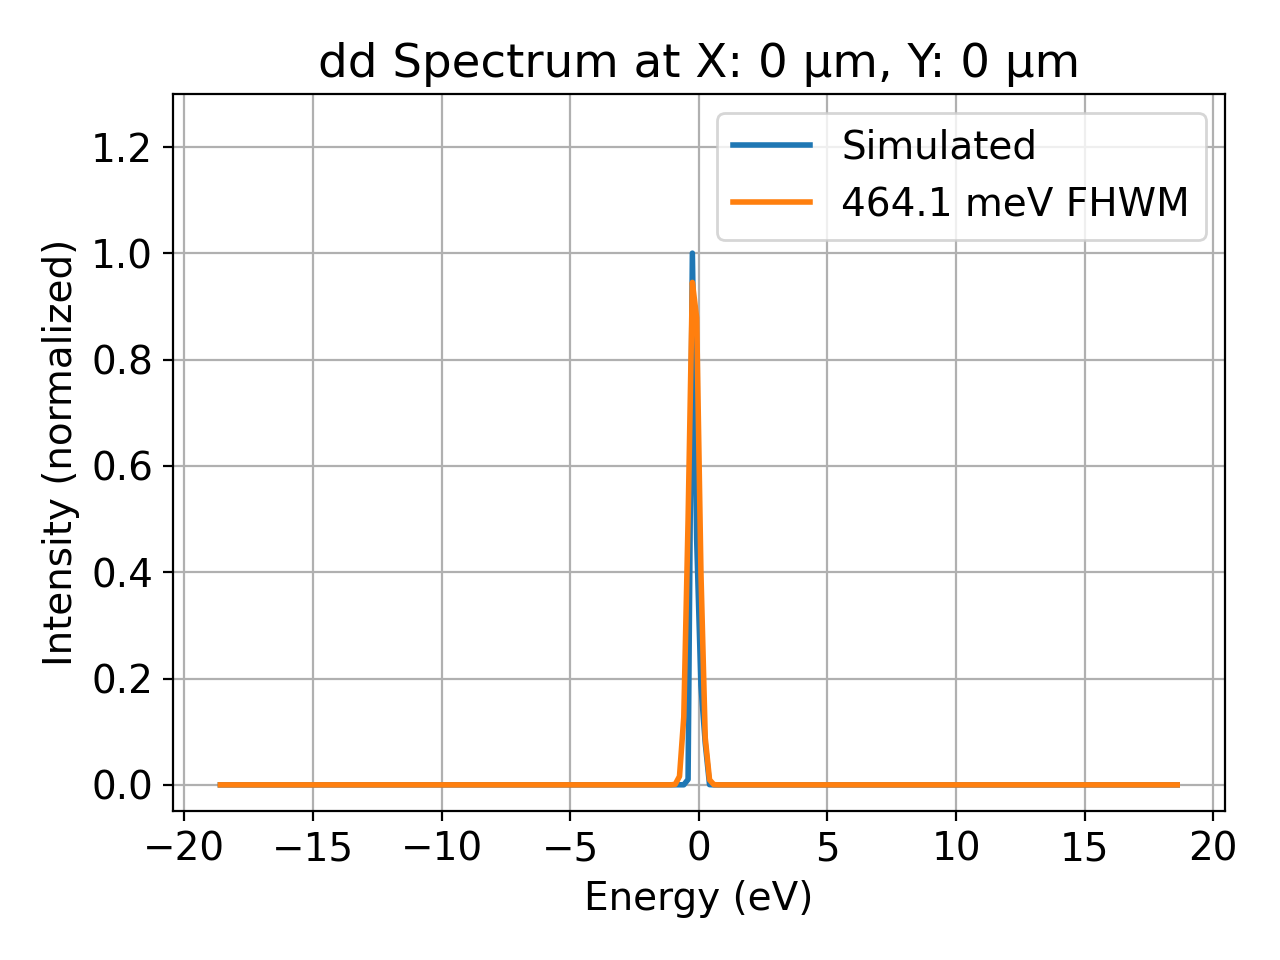

<IPython.core.display.Javascript object>


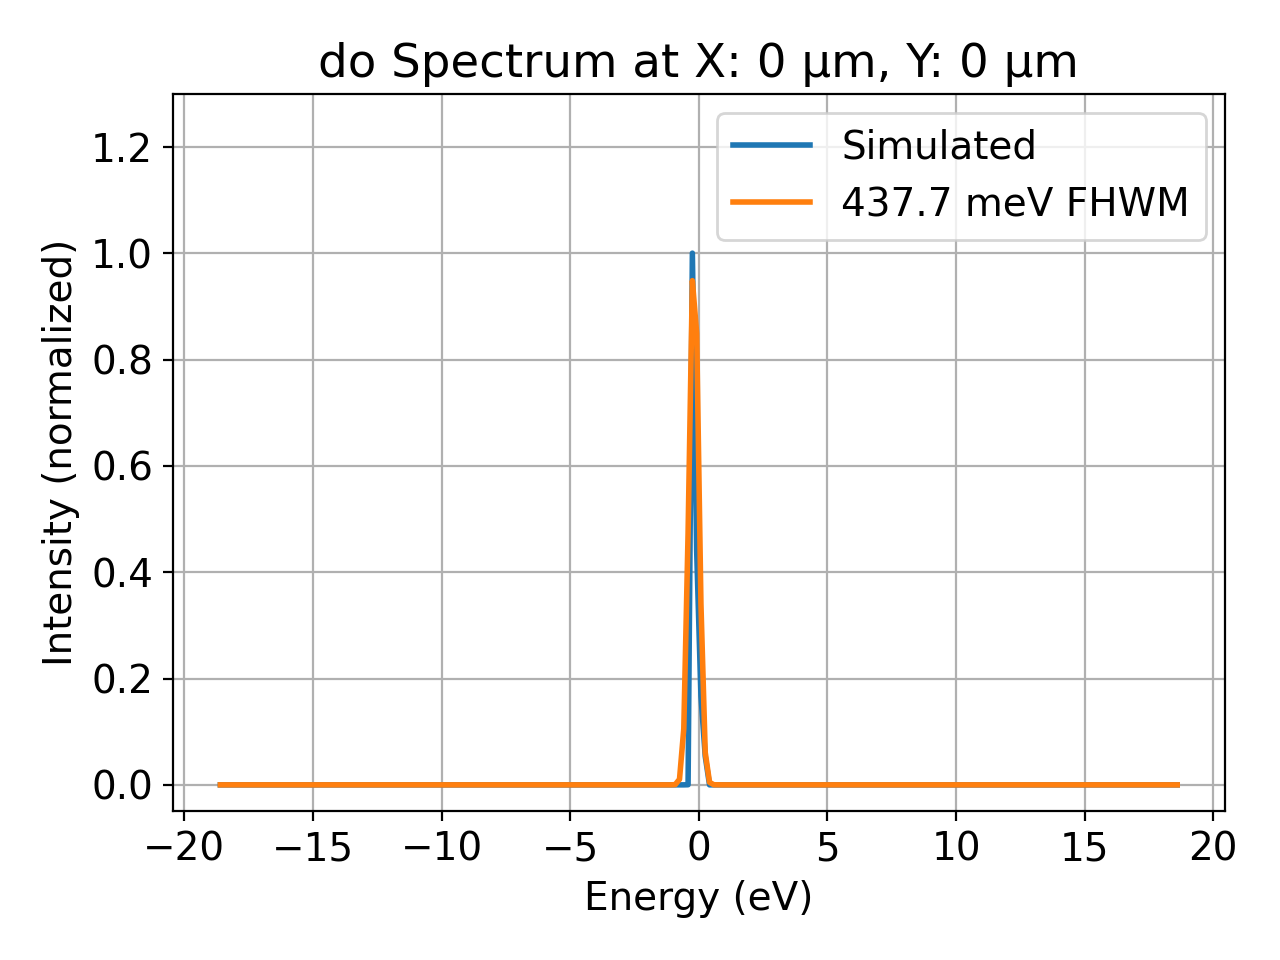

<IPython.core.display.Javascript object>


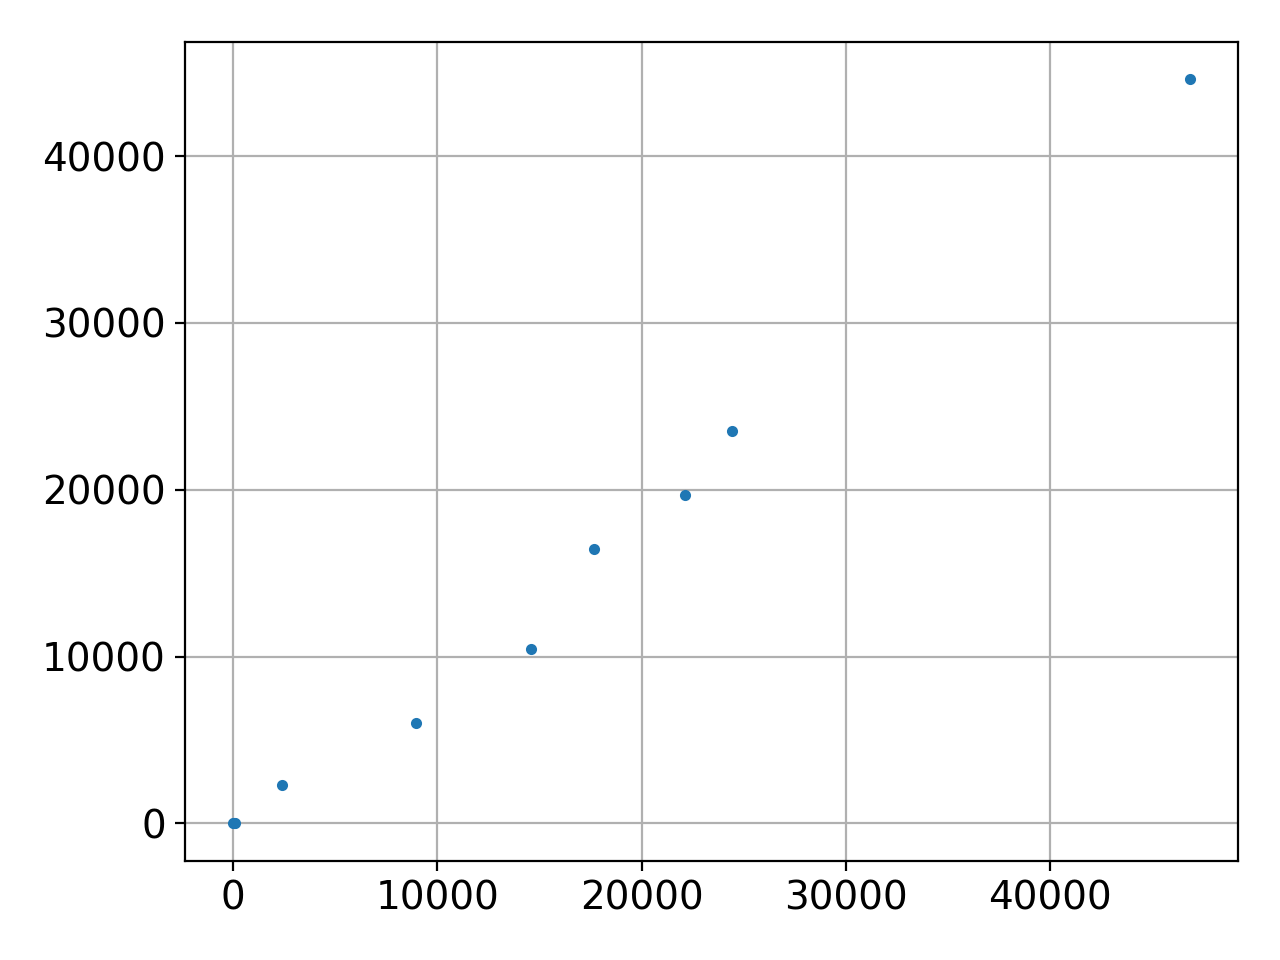

[24418.493536018705, 17673.65086054075, 8941.569931369782, 2403.9008975726497, 46855.158785558095, 14566.422950698927, 22.873087656965286, 22124.866725049927, 91.09941874966516, 3.0569837732751597]


In [164]:
pulses[0].plot_spectrum('dd')
pulses[0].plot_spectrum('do')
# pulse1.plot_spectrum('di')
# print(pulse1.throughput('di','dd'))
# print(pulse2.throughput('di','dd'))

xdata = [np.sum(np.abs(pulse.energy_stacks['dd'])**2) for pulse in pulses]
ydata = [np.sum(np.abs(pulse.energy_stacks['do'])**2) for pulse in pulses]

plt.figure()
plt.plot(xdata,ydata,'.')
plt.grid()
plt.tight_layout()

print(xdata)

# plt.figure()
# plt.plot([pulse1.throughput('di','dd'),pulse2.throughput('di','dd')],[pulse1.throughput('di','do'),pulse2.throughput('di','do')],'.')

In [169]:
%%capture capt

N = 11
rocking = np.zeros(N)

deltas = np.linspace(-1000e-6,1000e-6,N)
centroids = np.zeros_like(rocking)

# initialize split and delay object
snd = SND(9500)

# t1_tth positions
positions = snd.get_t1_tth() + deltas

pulses = []
# loop through positions
for num,pos in enumerate(positions):
    
    beam_params['photonEnergy'] = 9500
    pulse = beam.Pulse(beam_params=beam_params, tau=5, time_window=25, SASE=True, num_spikes=20)
    
    
    # make adjustment to t1_tth
    snd.mv_t1_tth(pos)
    # propagate beam through system
    pulse.propagate(beamline=snd.delay_branch,screen_names=['di','t1_dh','dd','do'])
    rocking[num] = np.sum(np.abs(pulse.energy_stacks['t1_dh'])**2)
#     pulses.append(pulse)
#     snd.propagate_delay()
    
    # get outputs
#     rocking[num] = snd.get_dd_sum()
#     centroids[num] = snd.get_dd_cx()

<IPython.core.display.Javascript object>


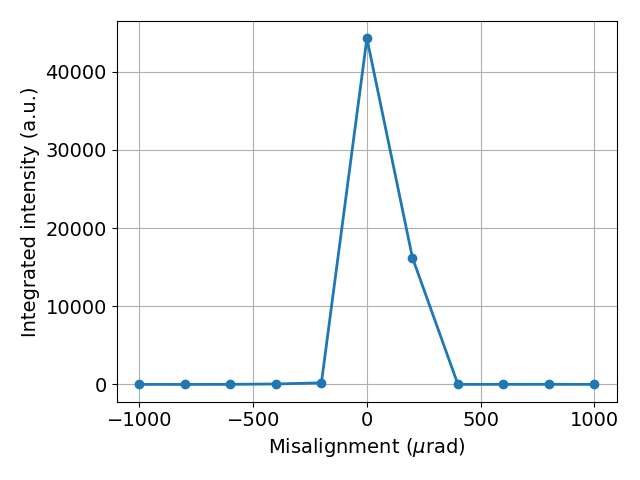

In [255]:
# rocking = [np.sum(np.abs(pulse.energy_stacks['t1_dh'])**2) for pulse in pulses]

plt.figure()
plt.plot(deltas*1e6,rocking,'o-')
plt.xlabel('Misalignment ($\mu$rad)')
plt.ylabel('Integrated intensity (a.u.)')
plt.grid()
plt.title('Rocking curve example')

In [201]:
%%capture capt


N = 50
do_delay = np.zeros(N)
do_cc = np.zeros(N)

snd = SND(9500)

for i in range(N):# pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True,N=20,spectral_width=5)
    beam_params['photonEnergy'] = 9500
    pulse = beam.Pulse(beam_params=beam_params, tau=5, time_window=25, SASE=True, num_spikes=20)
    pulse.propagate(beamline=snd.delay_branch,screen_names=['do'])
    do_delay[i] = np.sum(np.abs(pulse.energy_stacks['do'])**2)
    pulse.propagate(beamline=snd.cc_branch,screen_names=['do'])
    do_cc[i] = np.sum(np.abs(pulse.energy_stacks['do'])**2)

<IPython.core.display.Javascript object>


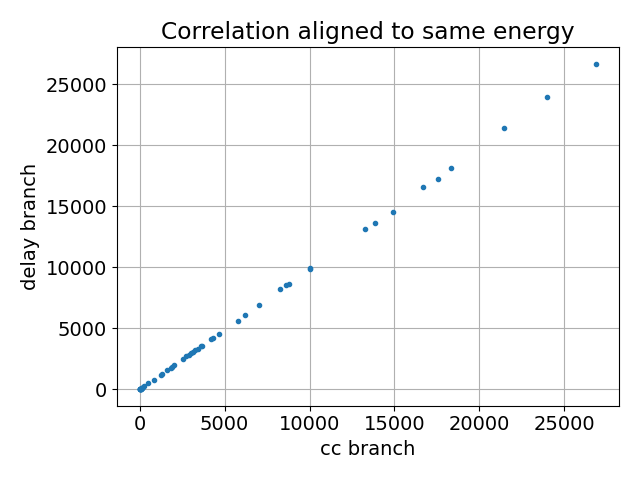

[[1.         0.99996524]
 [0.99996524 1.        ]]
0.9999652401176372


In [221]:
plt.figure()
plt.plot(do_cc,do_delay,'.')
plt.grid()
plt.xlabel('cc branch')
plt.ylabel('delay branch')
plt.title('Correlation aligned to same energy')


x = do_cc
y = do_delay
corr_array = np.zeros((2,np.size(x)))
corr_array[0,:] = x
corr_array[1,:] = y

print(np.corrcoef(corr_array))
n = np.size(x)
pearsonR = ((np.sum(x*y)-n*np.mean(x)*np.mean(y))/
            (np.sqrt(np.sum(x**2)-n*np.mean(x)**2)*np.sqrt(np.sum(y**2)-n*np.mean(y)**2)))
print(pearsonR)

In [204]:
%%capture capt
N=50
do_delay2 = np.zeros(N)
do_cc2 = np.zeros(N)

snd1 = SND(9500)
snd2 = SND(9501)


for i in range(N):# pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True,N=20,spectral_width=5)
    beam_params['photonEnergy'] = 9500
    pulse = beam.Pulse(beam_params=beam_params, tau=5, time_window=25, SASE=True, num_spikes=20)
    pulse.propagate(beamline=snd1.delay_branch,screen_names=['do'])
    do_delay2[i] = np.sum(np.abs(pulse.energy_stacks['do'])**2)
    pulse.propagate(beamline=snd2.cc_branch,screen_names=['do'])
    do_cc2[i] = np.sum(np.abs(pulse.energy_stacks['do'])**2)

<IPython.core.display.Javascript object>


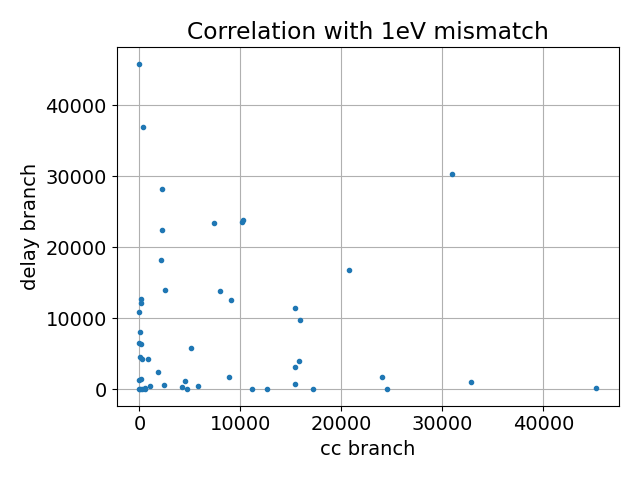

[[ 1.         -0.07137892]
 [-0.07137892  1.        ]]
-0.07137892054566893


In [222]:
plt.figure()
plt.plot(do_cc2,do_delay2,'.')
plt.grid()
plt.xlabel('cc branch')
plt.ylabel('delay branch')
plt.title('Correlation with 1eV mismatch')

x = do_cc2
y = do_delay2
corr_array = np.zeros((2,np.size(x)))
corr_array[0,:] = x
corr_array[1,:] = y

print(np.corrcoef(corr_array))
n = np.size(x)
pearsonR = ((np.sum(x*y)-n*np.mean(x)*np.mean(y))/
            (np.sqrt(np.sum(x**2)-n*np.mean(x)**2)*np.sqrt(np.sum(y**2)-n*np.mean(y)**2)))
print(pearsonR)

In [206]:
%%capture capt
N=50
do_delay3 = np.zeros(N)
do_cc3 = np.zeros(N)

snd1 = SND(9500)
snd2 = SND(9500.25)


for i in range(N):# pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True,N=20,spectral_width=5)
    beam_params['photonEnergy'] = 9500
    pulse = beam.Pulse(beam_params=beam_params, tau=5, time_window=25, SASE=True, num_spikes=20)
    pulse.propagate(beamline=snd1.delay_branch,screen_names=['do'])
    do_delay3[i] = np.sum(np.abs(pulse.energy_stacks['do'])**2)
    pulse.propagate(beamline=snd2.cc_branch,screen_names=['do'])
    do_cc3[i] = np.sum(np.abs(pulse.energy_stacks['do'])**2)

<IPython.core.display.Javascript object>


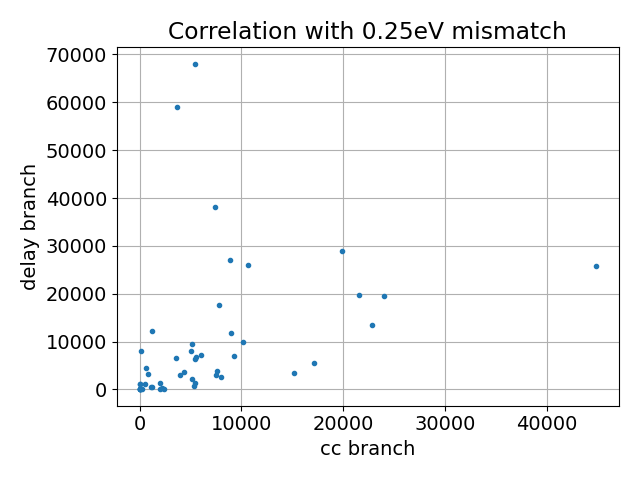

[[1.         0.35393176]
 [0.35393176 1.        ]]
0.35393175811794014


In [223]:
plt.figure()
plt.plot(do_cc3,do_delay3,'.')
plt.grid()
plt.xlabel('cc branch')
plt.ylabel('delay branch')
plt.title('Correlation with 0.25eV mismatch')

x = do_cc3
y = do_delay3
corr_array = np.zeros((2,np.size(x)))
corr_array[0,:] = x
corr_array[1,:] = y

print(np.corrcoef(corr_array))
n = np.size(x)
pearsonR = ((np.sum(x*y)-n*np.mean(x)*np.mean(y))/
            (np.sqrt(np.sum(x**2)-n*np.mean(x)**2)*np.sqrt(np.sum(y**2)-n*np.mean(y)**2)))
print(pearsonR)

In [208]:
%%capture capt
N=50
do_delay4 = np.zeros(N)
do_cc4 = np.zeros(N)

snd1 = SND(9500)
snd2 = SND(9500.5)


for i in range(N):# pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True,N=20,spectral_width=5)
    beam_params['photonEnergy'] = 9500
    pulse = beam.Pulse(beam_params=beam_params, tau=5, time_window=25, SASE=True, num_spikes=20)
    pulse.propagate(beamline=snd1.delay_branch,screen_names=['do'])
    do_delay4[i] = np.sum(np.abs(pulse.energy_stacks['do'])**2)
    pulse.propagate(beamline=snd2.cc_branch,screen_names=['do'])
    do_cc4[i] = np.sum(np.abs(pulse.energy_stacks['do'])**2)

<IPython.core.display.Javascript object>


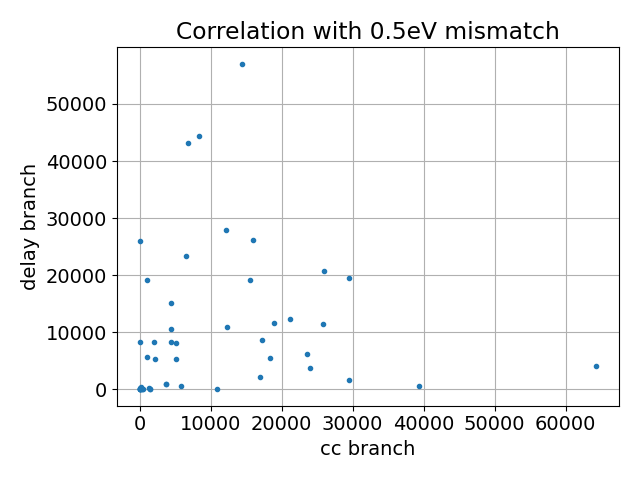

[[1.         0.11946495]
 [0.11946495 1.        ]]
0.11946494951002434


In [224]:
plt.figure()
plt.plot(do_cc4,do_delay4,'.')
plt.grid()
plt.xlabel('cc branch')
plt.ylabel('delay branch')
plt.title('Correlation with 0.5eV mismatch')

x = do_cc4
y = do_delay4
corr_array = np.zeros((2,np.size(x)))
corr_array[0,:] = x
corr_array[1,:] = y

print(np.corrcoef(corr_array))
n = np.size(x)
pearsonR = ((np.sum(x*y)-n*np.mean(x)*np.mean(y))/
            (np.sqrt(np.sum(x**2)-n*np.mean(x)**2)*np.sqrt(np.sum(y**2)-n*np.mean(y)**2)))
print(pearsonR)

In [210]:
%%capture capt
N=50
do_delay5 = np.zeros(N)
do_cc5 = np.zeros(N)

snd1 = SND(9500)
snd2 = SND(9500.1)


for i in range(N):# pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True,N=20,spectral_width=5)
    beam_params['photonEnergy'] = 9500
    pulse = beam.Pulse(beam_params=beam_params, tau=5, time_window=10, SASE=True, num_spikes=20)
    pulse.propagate(beamline=snd1.delay_branch,screen_names=['do'])
    do_delay5[i] = np.sum(np.abs(pulse.energy_stacks['do'])**2)
    pulse.propagate(beamline=snd2.cc_branch,screen_names=['do'])
    do_cc5[i] = np.sum(np.abs(pulse.energy_stacks['do'])**2)

<IPython.core.display.Javascript object>


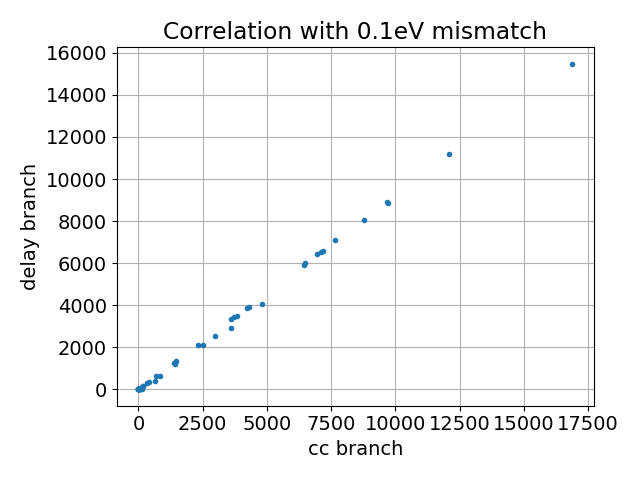

[[1.         0.99967028]
 [0.99967028 1.        ]]
0.9996702750682334


In [225]:
plt.figure()
plt.plot(do_cc5,do_delay5,'.')
plt.grid()
plt.xlabel('cc branch')
plt.ylabel('delay branch')
plt.title('Correlation with 0.1eV mismatch')

x = do_cc5
y = do_delay5
corr_array = np.zeros((2,np.size(x)))
corr_array[0,:] = x
corr_array[1,:] = y

print(np.corrcoef(corr_array))
n = np.size(x)
pearsonR = ((np.sum(x*y)-n*np.mean(x)*np.mean(y))/
            (np.sqrt(np.sum(x**2)-n*np.mean(x)**2)*np.sqrt(np.sum(y**2)-n*np.mean(y)**2)))
print(pearsonR)

In [214]:
np.savez('correlations2.npz',do_cc=do_cc,do_delay=do_delay,do_cc2=do_cc2,do_delay2=do_delay2,do_cc3=do_cc3,
        do_delay3=do_delay3,do_cc4=do_cc4,do_delay4=do_delay4,do_cc5=do_cc5,do_delay5=do_delay5)

<IPython.core.display.Javascript object>


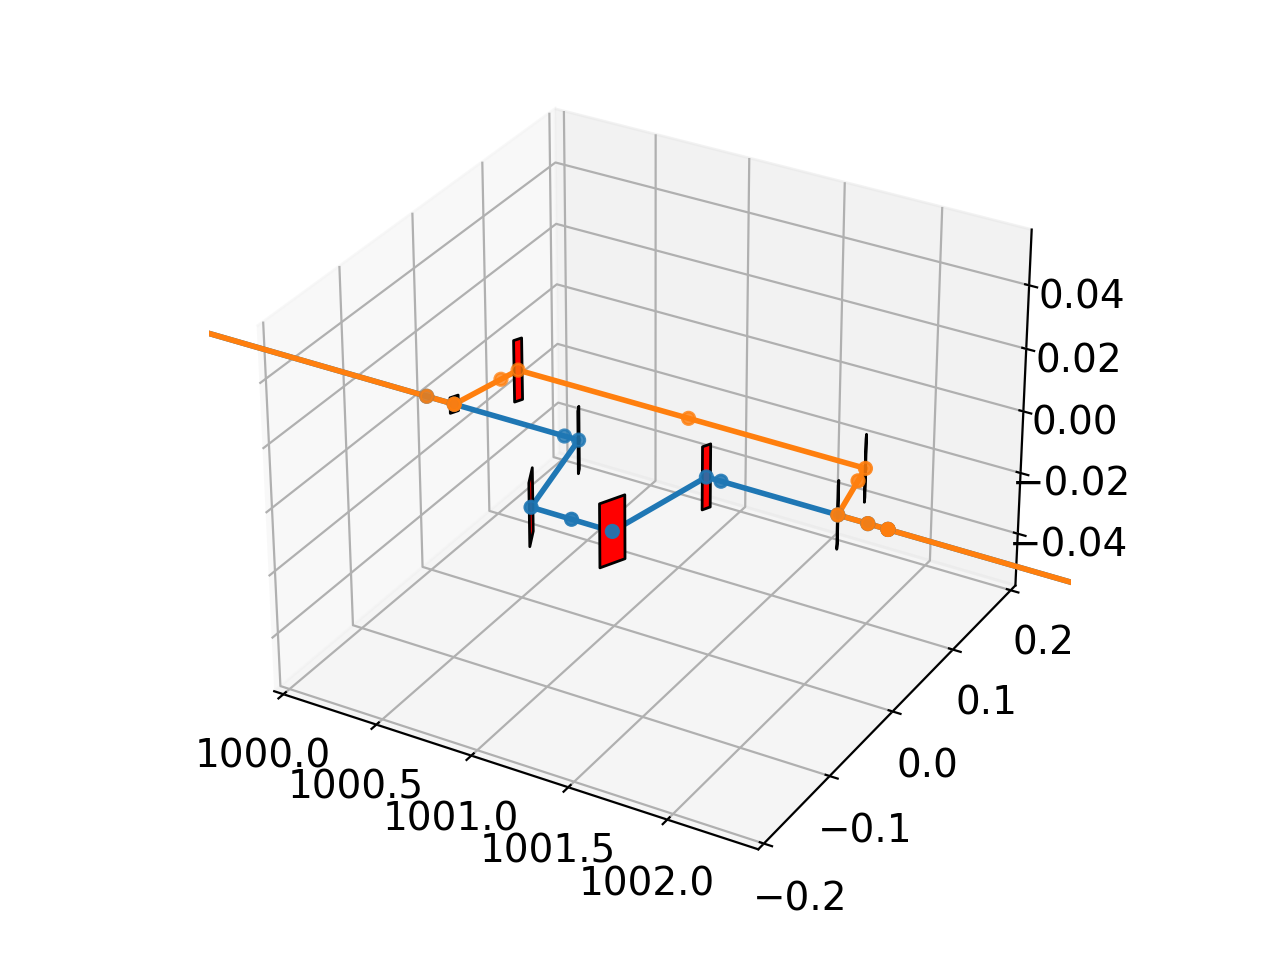

(-0.2, 0.2)

In [192]:
ax,zs = snd.cc_branch.draw_beamline()
snd.delay_branch.draw_beamline(ax=ax)
ax.set_xlim(1000,1002.4)
ax.set_ylim(-.2,.2)

In [6]:
g1 = optics.TransmissionGrating('g1',pitch=200e-9,E0=9500)

In [7]:
2e-3/g1.beta0

3.065010268053389

In [59]:
np.log(.6)

-0.5108256237659907

In [63]:
-np.log(np.sqrt(2*(2e-8)**2))

17.380959973112446

In [6]:
import numpy as np
np.exp(-(2*np.pi/(1240/500*1e-9)*2*25e-3*1.6e-9)**2)

0.9597518097825316

In [7]:
np.exp(30)

10686474581524.463